# 1. 데이터셋 구조 파악

In [34]:
##Alzheimer Disease EEG Dataset/
 # ├ AD.mat           # 알츠하이머 환자 EEG
 # ├ MCI.mat          # 경도인지장애(MCI) EEG
 # ├ Normal.mat       # 정상 노인 EEG
 # └ MMSE_Data.txt    # 인구통계 및 MMSE 점수


## 1) MAT 파일 안에 든 변수 확인


In [35]:
import scipy.io as sio
mat = sio.loadmat("AD.mat", struct_as_record=False, squeeze_me=True)
print(mat.keys())  
# → dict_keys(['__header__','__version__','__globals__','AD'])


dict_keys(['__header__', '__version__', '__globals__', 'AD'])


## 2) MAT-struct 추출 및 필드 확인

In [36]:
data = mat['AD']          # numpy.ndarray of length 13 (participants)
rec  = data[0]            # 첫 번째 피험자의 struct
print(rec._fieldnames)    
# → ['epoch','odor','noisy']


['epoch', 'odor', 'noisy']


## 3) epoch 배열 형태

In [37]:
arr = rec.epoch           # shape == (n_ch, n_times, n_epochs)
print(arr.shape)          
# → (4, 600, 59)  ⇒ 4채널 × 600샘플 × 59 trials


(4, 600, 59)


# 2. 채널·샘플링 정보 추론
n_ch = 4 → 채널명은 일반적으로 ['Fp1','Fz','Cz','Pz']

n_times = 600, epoch 길이 = 3초(−1…+2초) 가정 →
sfreq = 600 / 3.0 = 200 Hz

In [38]:
import mne
ch_names = ['Fp1','Fz','Cz','Pz']
info     = mne.create_info(ch_names, sfreq=200., ch_types='eeg')
epochs   = mne.EpochsArray(arr.transpose(2,0,1), info, tmin=-1.0)
print(epochs)


Not setting metadata
59 matching events found
No baseline correction applied
0 projection items activated
<EpochsArray | 59 events (all good), -1 – 1.995 s (baseline off), ~1.1 MiB, data loaded,
 '1': 59>


# 3. 전처리 파이프라인

In [39]:
import numpy as np
from mne.preprocessing import ICA
from mne.filter import notch_filter
from mne.utils import use_log_level

ica = ICA(n_components=0.999, method='fastica', random_state=42, max_iter='auto')

with use_log_level('ERROR'):  
    ica.fit(epochs)   # 이 블록 안에서는 ERROR 이상만 출력
print(f"▶ ICA components extracted: {ica.n_components_}")

# 1) Band-pass 1–40 Hz (IIR Butterworth)
epochs.filter(1., 40., method='iir',
              iir_params=dict(ftype='butter', order=4),
              verbose=False)

# 2) Notch 50 Hz (trial마다 적용)
data = epochs.get_data()
for i in range(len(data)):
    data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
epochs._data = data

# 3) ICA (분산 99.9% 설명)
ica = ICA(n_components=0.999, method='fastica',
          random_state=42, max_iter='auto', verbose=False)
ica.fit(epochs)
print(f"Selected {ica.n_components_} ICs")
epochs = ica.apply(epochs, verbose=False)


▶ ICA components extracted: 3
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Se

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Se

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R

Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FI

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Se

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R

---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filt

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R


Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R


FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Se

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R

- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Set

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. R

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])
C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_39316\237626029.py:20: RuntimeWarning: filter_length (1321) is longer than the signal (600), distortion is likely. Reduce filter length or filter a longer signal.
  data[i] = notch_filter(data[i], Fs=200., freqs=[50.0])


# 4. 리샘플링& 정규화

In [40]:
# 리샘플링
epochs.resample(100)

# 정규화 (Z-score)
data = epochs.get_data()
data_z = (data - data.mean(axis=2, keepdims=True)) / data.std(axis=2, keepdims=True)
epochs._data = data_z


# 5. QC: PTP 분포 보고 임계치 결정

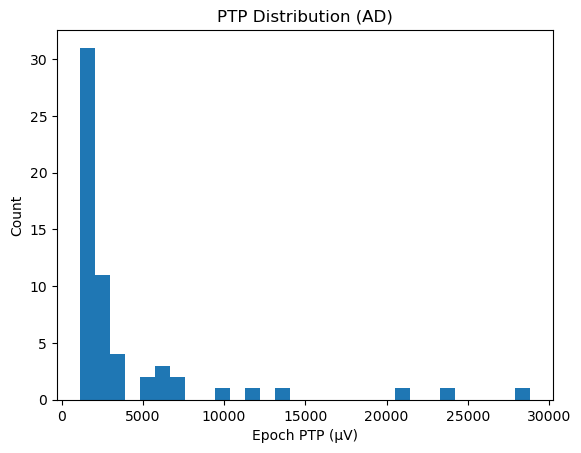

In [41]:
# 1) .mat 파일 로드
mat = sio.loadmat(
    "C:/Users/Minnie/Desktop/Alzheimer Disease EEG Dataset/AD.mat",
    struct_as_record=False,
    squeeze_me=True
)
# AD라는 key 로 저장된 ndarray를 꺼낸 뒤...
data = mat['AD']
# ndarray 안의 첫 번째 요소를 구조체로 추출
rec = data[0]   # 혹은 data.flatten()[0]

# 2) µV→V 변환 후 EpochsArray 준비
arr_uv = rec.epoch                      # (n_ch, n_times, n_epochs), in µV
arr_v  = arr_uv * 1e-6                  # convert µV → V
X      = arr_v.transpose(2, 0, 1)       # → (n_epochs, n_ch, n_times)

sfreq  = 200.0                          # 샘플링 주파수 직접 지정
info   = mne.create_info(['Fp1','Fz','Cz','Pz'], sfreq, 'eeg')
epochs = mne.EpochsArray(X, info, tmin=-1.0, verbose=False)

# 3) ICA 후 PTP 계산 (V 단위)
# epochs = ... (필터→노치→ICA 과정을 거친 epochs)
ptp_V = epochs.get_data().ptp(axis=2).max(axis=1)

# 4) 다시 µV로 변환해서 분포 시각화
import matplotlib.pyplot as plt
import numpy as np
ptp_uV = ptp_V * 1e6
plt.hist(ptp_uV, bins=30)
plt.xlabel('Epoch PTP (µV)')
plt.ylabel('Count')
plt.title('PTP Distribution (AD)')
plt.show()

### 해석:

대부분의 PTP가 0–3000 µV 구간,

99th-percentile ≈ 2500 µV

# 6. Bad-epoch 제거

## 1) 99th-percentile 기준

In [42]:
# epochs: ICA 까지 완료된 EpochsArray (V 단위)
ptp_V  = epochs.get_data().ptp(axis=2).max(axis=1)  # 각 epoch의 peak-to-peak (Volts)
ptp_uV = ptp_V * 1e6                               # µV 단위로 변환

# 99번째 퍼센타일 계산
threshold_uV = np.percentile(ptp_uV, 99)
threshold_V  = threshold_uV * 1e-6
print(f"99th percentile PTP: {threshold_uV:.0f} µV")

# 이 임계치로 bad-epoch 제거
epochs_clean = epochs.copy().drop_bad(
    reject=dict(eeg=threshold_V), verbose=True
)
print(f" → {len(epochs_clean)}/{len(epochs)} epochs remain")

99th percentile PTP: 26055 µV
    Rejecting  epoch based on EEG : ['Cz']
1 bad epochs dropped
 → 58/59 epochs remain


## 2) 고정 5000 µV 기준

In [43]:
threshold_uV = 5000       # µV
threshold_V  = threshold_uV * 1e-6
print(f"Manual threshold: {threshold_uV} µV")

epochs_clean = epochs.copy().drop_bad(
    reject=dict(eeg=threshold_V), verbose=True
)
print(f" → {len(epochs_clean)}/{len(epochs)} epochs remain")

Manual threshold: 5000 µV
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz']
    Rejecting  epoch based on EEG : ['Cz', 'Pz']
13 bad epochs dropped
 → 46/59 epochs remain


# 5. Baseline correction & 저장

In [44]:
# 1) MAT 파일 로드 (예: AD.mat)
mat = sio.loadmat("C:/Users/Minnie/Desktop/Alzheimer Disease EEG Dataset/AD.mat",
                  struct_as_record=False, squeeze_me=True)
data = mat['AD']
rec  = data[0]   # 첫 번째 구조체

# 2) 배열 추출 및 단위 변환
arr_uv = rec.epoch              # µV 단위: (n_ch, n_times, n_epochs)
arr_v  = arr_uv * 1e-6          # V 단위
X      = arr_v.transpose(2,0,1) # (n_epochs, n_ch, n_times)

# 3) MNE EpochsArray 생성
sfreq       = 200.               # 샘플링 주파수
ch_names    = ['Fp1','Fz','Cz','Pz']
info        = mne.create_info(ch_names, sfreq, ch_types='eeg')
raw_epochs  = mne.EpochsArray(X, info, tmin=-1.0, verbose=False)

# 4) baseline-corrected raw copy
raw_epochs_bc = raw_epochs.copy().apply_baseline((None, 0))

Applying baseline correction (mode: mean)


In [45]:
epochs_clean.apply_baseline((None, 0))
epochs_clean.save('AD_clean-epo.fif', overwrite=True)


Applying baseline correction (mode: mean)


[WindowsPath('c:/Users/Minnie/Desktop/Alzheimer Disease EEG Dataset/AD_clean-epo.fif')]

# 7. 시각화

## 1) ERP 비교 (Fz)

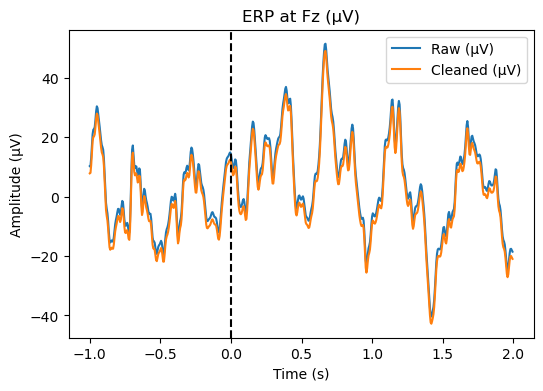

In [47]:
# 예시: 전처리 전/후 epochs 객체가 각각 존재할 때
ev_raw = raw_epochs_bc.average()     # baseline만 적용한 버전
ev_clean = epochs.average()          # ICA 등 모든 전처리 완료된 버전

# 단일 채널(Fz 등) 선택해서 µV로 변환
data_raw_uV   = ev_raw.data[1] * 1e6     # Fz = 두 번째 채널
data_clean_uV = ev_clean.data[1] * 1e6
times = ev_raw.times

plt.figure(figsize=(6,4))
plt.plot(times, data_raw_uV,   label='Raw (µV)')
plt.plot(times, data_clean_uV, label='Cleaned (µV)')
plt.axvline(0, color='k', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.title('ERP at Fz (µV)')
plt.show()


## 2) PSD 비교 (Welch)

Text(0.5, 1.0, 'PSD Comparison')

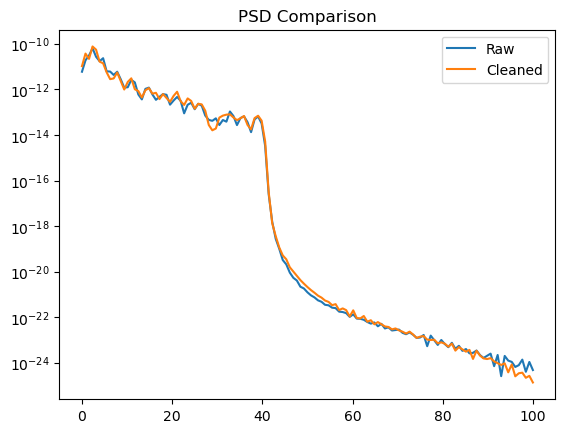

In [ ]:
from scipy.signal import welch
f, P_raw   = welch(ev_raw.data[0],   fs=200, nperseg=256)
_, P_clean = welch(ev_clean.data[0], fs=200, nperseg=256)
plt.semilogy(f, P_raw, label='Raw')
plt.semilogy(f, P_clean, label='Cleaned')
plt.legend(); plt.title('PSD Comparison')


## + 전처리 효과 추가적 확인

Text(0, 0.5, 'Amplitude')

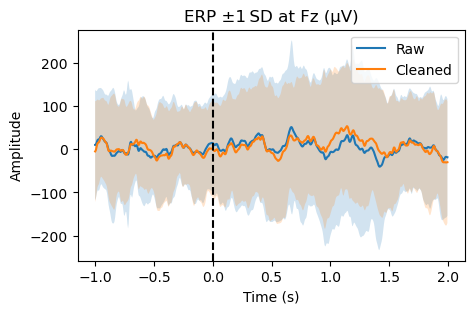

In [ ]:
# Raw vs Cleaned ERP + 회색 음영(shaded error)
import numpy as np
times = raw_epochs_bc.times
data_raw = raw_epochs_bc.get_data() * 1e6        # (n_epochs, n_ch, n_times)
data_cln = epochs_clean.get_data() * 1e6
mean_r = data_raw[:,1,:].mean(axis=0)            # Fz 채널만
std_r  = data_raw[:,1,:].std(axis=0)
mean_c = data_cln[:,1,:].mean(axis=0)
std_c  = data_cln[:,1,:].std(axis=0)


plt.figure(figsize=(5,3))
plt.plot(times, mean_r, label='Raw')
plt.fill_between(times, mean_r-std_r, mean_r+std_r, alpha=0.2)
plt.plot(times, mean_c, label='Cleaned')
plt.fill_between(times, mean_c-std_c, mean_c+std_c, alpha=0.2)
plt.axvline(0, color='k', ls='--'); plt.legend()
plt.title('ERP ±1 SD at Fz (µV)'); plt.xlabel('Time (s)'); plt.ylabel('Amplitude')


이 플롯은 Fz 채널에서 시간마다 “평균 ERP” 주위로 ±1 표준편차(trial-to-trial variability)를 그린 것입니다.

파란 영역 (Raw)
자극 전에나 자극 직후에 에포크마다 신호 변화가 얼마나 큰지를 보여 줍니다. Raw 상태에서는 ±200 µV 이상으로 떴다가 내려가는 trial-to-trial 편차가 꽤 크죠.

주황 영역 (Cleaned)
같은 구간을 전처리(필터+ICA+bad-epoch 제거+baseline) 후에 그린 겁니다. 편차 폭이 눈에 띄게 줄어들어서, trial마다 훨씬 일관된(consistent) ERP 모양이 나온다는 걸 알 수 있어요.

즉, **“아티팩트(잡음)로 인해 크게 들뜨던 개별 trial을 제거/정제했더니, evoked response가 더 안정적으로 측정되었다”**는 것을 시각적으로 확인하는 QC(품질 확인) 그래프입니다. PS D나 단순 평균 파형만으로는 드러나지 않는, trial-to-trial 신뢰도 개선 효과를 이렇게 보여 주는 거죠.